# Análisis de nacimientos según fase lunar

Este análisis explora la relación entre la fase lunar y la cantidad de nacimientos diarios. Se utilizan datos históricos que incluyen la fecha de nacimiento y la fase lunar correspondiente. Se realiza una exploración inicial, limpieza básica y análisis estadístico para detectar patrones o diferencias significativas entre grupos.

**Objetivo**: Determinar si existe alguna relación estadísticamente significativa entre la fase lunar y los nacimientos, así como por día de la semana, fin de semana, mes y década.

**Técnicas utilizadas**:
- Estadísticas descriptivas
- Visualizaciones (BoxPlot, Heatmap)
- Pruebas ANOVA
- Prueba post-hoc de Tukey HSD

**Principales hallazgos**:
- No se encontró relación significativa entre la fase lunar y los nacimientos.
- Sí se encontraron diferencias estadísticamente significativas entre días de la semana y entre meses.


## Estructura del análisis

1. Importación y preparación de los datos  
2. Exploración inicial  
3. Limpieza y validaciones  
4. Análisis estadístico por fase lunar, día de la semana y mes  
5. Visualizaciones complementarias  
6. Conclusiones


## Carga inicial de Librerias y archivo de datos


In [45]:
# Cargar librerías necesarias
import pandas as pd
from datetime import datetime
import ephem
#from astral.moon import moon_phase
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd



In [46]:
# Definir la carpeta y el archivo
carpetaDatos = 'data'
archivoNacimientos = 'births.csv'

# Cargar el archivo CSV
rutaArchivo = f'{carpetaDatos}/{archivoNacimientos}'
dfNacimientos = pd.read_csv(rutaArchivo, parse_dates=['date'])

# Mostrar las primeras filas
dfNacimientos.head()


,date,state,births
0,1920-01-01,Malaysia,96
1,1920-01-02,Malaysia,115
2,1920-01-03,Malaysia,111
3,1920-01-04,Malaysia,101
4,1920-01-05,Malaysia,95


## Análisis exploratorio de datos

### Vista General del Dataset

Hacemos una revision general de los datos.

In [47]:
# Dimensiones del DataFrame
print("Filas y columnas:", dfNacimientos.shape)

# Primeras filas del DataFrame
display(dfNacimientos.head())

# Información de tipos de datos y valores nulos
dfNacimientos.info()

# Número de valores nulos por columna
print("\nValores nulos por columna:")
print(dfNacimientos.isnull().sum())

# Verificar duplicados
print("\nNúmero de filas duplicadas:", dfNacimientos.duplicated().sum())

# Estadísticas descriptivas de las columnas numéricas
display(dfNacimientos.describe())


Filas y columnas: (37833, 3)


,date,state,births
0,1920-01-01,Malaysia,96
1,1920-01-02,Malaysia,115
2,1920-01-03,Malaysia,111
3,1920-01-04,Malaysia,101
4,1920-01-05,Malaysia,95


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37833 entries, 0 to 37832
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    37833 non-null  datetime64[ns]
 1   state   37833 non-null  object        
 2   births  37833 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 886.8+ KB

Valores nulos por columna:
date      0
state     0
births    0
dtype: int64

Número de filas duplicadas: 0


,date,births
count,37833,37833.000000
mean,1971-10-16 00:00:00.000000008,950.482991
min,1920-01-01 00:00:00,43.000000
25%,1945-11-23 00:00:00,459.000000
50%,1971-10-16 00:00:00,1046.000000
75%,1997-09-07 00:00:00,1379.000000
max,2023-07-31 00:00:00,3868.000000
std,NaN,491.371681


### Revisión de las fechas

Antes de realizar cualquier análisis, es fundamental asegurarnos de que las fechas en el dataset estén correctamente registradas.

Este paso revisa:

- El rango de fechas disponible.
- Si hay fechas duplicadas.
- Si hay días faltantes (saltos en el calendario).
- Si el formato y tipo de dato es correcto.


In [48]:
# Revisar el tipo de dato y valores únicos
print("Tipo de dato de la columna 'fecha':", dfNacimientos['date'].dtype)
print("Primeras fechas:", dfNacimientos['date'].min())
print("Últimas fechas:", dfNacimientos['date'].max())
print("Cantidad total de fechas únicas:", dfNacimientos['date'].nunique())
print("Cantidad total de registros:", len(dfNacimientos))

# Verificar si hay fechas duplicadas
duplicadas = dfNacimientos['date'].duplicated().sum()
print("Cantidad de fechas duplicadas:", duplicadas)


Tipo de dato de la columna 'fecha': datetime64[ns]
Primeras fechas: 1920-01-01 00:00:00
Últimas fechas: 2023-07-31 00:00:00
Cantidad total de fechas únicas: 37833
Cantidad total de registros: 37833
Cantidad de fechas duplicadas: 0


In [49]:
# Crear un rango completo de fechas entre el mínimo y máximo
rangoCompleto = pd.date_range(start=dfNacimientos['date'].min(), end=dfNacimientos['date'].max(), freq='D')

# Identificar fechas que faltan en el dataset
fechasFaltantes = rangoCompleto.difference(dfNacimientos['date'])
print(f"Cantidad de fechas faltantes: {len(fechasFaltantes)}")
print(f"Fechas faltantes (si hay):\n{fechasFaltantes}")


Cantidad de fechas faltantes: 0
Fechas faltantes (si hay):
DatetimeIndex([], dtype='datetime64[ns]', freq='D')


### Revisión de la columna births

En este paso verificamos que no hay valores nulos ni negativos.


In [50]:
# Verificar si hay valores nulos
print("Cantidad de valores nulos en 'births':", dfNacimientos['births'].isnull().sum())

# Verificar si hay valores negativos
valoresNegativos = dfNacimientos[dfNacimientos['births'] < 0]
print("Cantidad de valores negativos en 'births':", len(valoresNegativos))

# Estadísticas descriptivas
dfNacimientos['births'].describe()



Cantidad de valores nulos en 'births': 0
Cantidad de valores negativos en 'births': 0


count    37833.000000
mean       950.482991
std        491.371681
min         43.000000
25%        459.000000
50%       1046.000000
75%       1379.000000
max       3868.000000
Name: births, dtype: float64

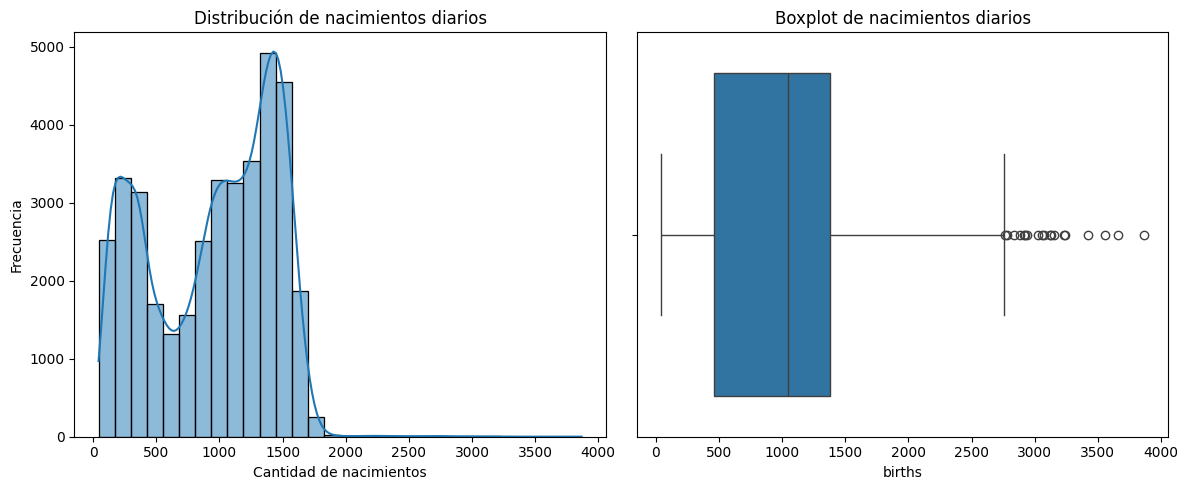

In [51]:
# Visualización con histograma y BoxPlot

plt.figure(figsize=(12, 5))

# Histograma
plt.subplot(1, 2, 1)
sns.histplot(dfNacimientos['births'], bins=30, kde=True)
plt.title('Distribución de nacimientos diarios')
plt.xlabel('Cantidad de nacimientos')
plt.ylabel('Frecuencia')

# Boxplot para detección visual de outliers
plt.subplot(1, 2, 2)
sns.boxplot(x=dfNacimientos['births'])
plt.title('Boxplot de nacimientos diarios')

plt.tight_layout()
plt.show()


### Identificación de outliers (valores atípicos)
Vamos a analizar los días con una cantidad de nacimientos excepcionalmente alta. Estos valores pueden representar situaciones especiales o posibles errores, por lo que es útil revisarlos antes de continuar con el análisis.

In [52]:
# Definir el umbral del percentil 99.5
umbralOutliers = dfNacimientos['births'].quantile(0.995)

# Filtrar los outliers
dfOutliers = dfNacimientos[dfNacimientos['births'] > umbralOutliers]

# Mostrar resultados
print(f"Umbral de nacimientos para el percentil 99.5: {umbralOutliers:.2f}")
print(f"Cantidad de días considerados outliers: {len(dfOutliers)}")

# Mostrar las primeras filas
dfOutliers.head(10)


Umbral de nacimientos para el percentil 99.5: 1739.00
Cantidad de días considerados outliers: 187


,date,state,births
1460,1923-12-31,Malaysia,1777
1826,1924-12-31,Malaysia,1931
2556,1926-12-31,Malaysia,1837
2921,1927-12-31,Malaysia,1873
3287,1928-12-31,Malaysia,2445
3652,1929-12-31,Malaysia,2580
4017,1930-12-31,Malaysia,2716
4382,1931-12-31,Malaysia,2631
4748,1932-12-31,Malaysia,2715
5113,1933-12-31,Malaysia,2917


### Revisión de valores para el 31 de diciembre
En esta sección evaluamos si los nacimientos reportados el 31 de diciembre presentan consistentemente valores inusuales o si esto ocurre solo en ciertos años. Esto es importante ya que detectamos que algunos días 31 de diciembre tienen un número de nacimientos significativamente más alto que el resto del año, lo cual podría indicar errores de captura, agrupamiento de fechas por falta de precisión, o prácticas administrativas en el registro de nacimientos.

In [53]:
# Filtrar todos los registros del 31 de diciembre
dic31 = dfNacimientos[
    (dfNacimientos['date'].dt.month == 12) &
    (dfNacimientos['date'].dt.day == 31)
]

# Mostrar estadísticas descriptivas de los nacimientos ese día
print("Estadísticas de nacimientos el 31 de diciembre:")
print(dic31['births'].describe())

# Mostrar los 10 valores más altos para revisión visual
dic31.sort_values(by='births', ascending=False).head(10)


Estadísticas de nacimientos el 31 de diciembre:
count     103.000000
mean     1793.961165
std       654.547860
min      1056.000000
25%      1257.000000
50%      1570.000000
75%      2233.500000
max      3868.000000
Name: births, dtype: float64


,date,state,births
6209,1936-12-31,Malaysia,3868
5843,1935-12-31,Malaysia,3656
5478,1934-12-31,Malaysia,3150
10957,1949-12-31,Malaysia,3125
6939,1938-12-31,Malaysia,3024
6574,1937-12-31,Malaysia,2939
5113,1933-12-31,Malaysia,2917
10592,1948-12-31,Malaysia,2838
9496,1945-12-31,Malaysia,2777
10226,1947-12-31,Malaysia,2759


### Análisis de Outliers por Año

Aunque identificamos valores atípicos como el 31 de diciembre en algunos años, es posible que existan otros días con comportamientos inusuales que podrían afectar los análisis estadísticos.

En este paso, realizaremos una revisión por año para detectar días con cantidades de nacimientos anormalmente altas. Para ello:

- Agrupamos los datos por año.
- Calculamos, para cada año, el promedio y desviación estándar diaria.
- Identificamos días cuyo número de nacimientos supera el percentil 99.5 de ese año.
- Registramos los días detectados como outliers para una revisión posterior.

Este análisis nos permitirá depurar mejor el dataset y tomar decisiones informadas sobre qué datos conservar o excluir.


In [54]:
# Extraer el año desde la fecha si no existe
dfNacimientos['anio'] = dfNacimientos['date'].dt.year

# Crear lista para almacenar outliers
outliersAnuales = []

# Iterar por cada año único
for anio, grupo in dfNacimientos.groupby('anio'):
    q995 = grupo['births'].quantile(0.995)
    # Filtrar días que superan ese valor
    outliers = grupo[grupo['births'] > q995].copy()
    outliers['umbral_995'] = q995
    outliersAnuales.append(outliers)

# Combinar todos los outliers encontrados en un solo DataFrame
dfOutliersAnuales = pd.concat(outliersAnuales, ignore_index=True)

# Mostrar resumen
print(f"Total de días considerados outliers entre todos los años: {len(dfOutliersAnuales)}")

# Mostrar las primeras filas
dfOutliersAnuales.head()


Total de días considerados outliers entre todos los años: 206


,date,state,births,anio,umbral_995
0,1920-11-30,Malaysia,248,1920,219.95
1,1920-12-31,Malaysia,1104,1920,219.95
2,1921-11-30,Malaysia,228,1921,219.80
3,1921-12-31,Malaysia,1256,1921,219.80
4,1922-11-30,Malaysia,224,1922,205.14


### Visualización de Outliers a lo Largo del Tiempo
Ahora que identificamos días con cantidades de nacimientos atípicamente altas comparadas con el comportamiento de su mismo año, es útil visualizar cómo se distribuyen estos outliers en el tiempo. Esto nos permitirá detectar si hay ciertos días específicos (como fin de año) que se repiten o si los outliers están repartidos aleatoriamente.

C:\Users\mianz\AppData\Local\Temp\ipykernel_24852\3760218679.py:23: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\DataS504\Python\Nac Luna llena\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


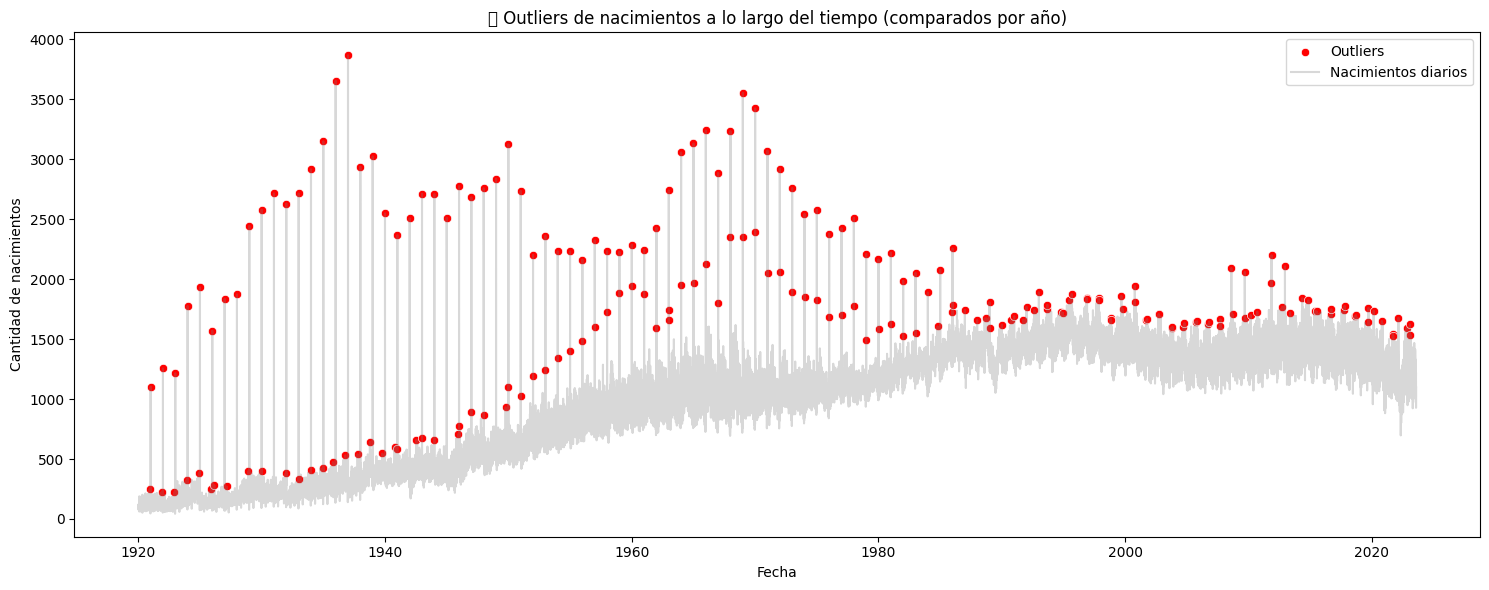

In [55]:
# Calcular umbrales por año
outliersAnuales = []

for year, grupo in dfNacimientos.groupby(dfNacimientos['date'].dt.year):
    umbral = grupo['births'].quantile(0.995)
    outliers = grupo['births'] > umbral
    outliersAnuales.extend(outliers.tolist())

# Agregar columna al DataFrame
dfNacimientos['esOutlierAnual'] = outliersAnuales

# Filtrar los outliers detectados anteriormente
outliersPorAno = dfNacimientos[dfNacimientos['esOutlierAnual']]

# Crear gráfico de dispersión
plt.figure(figsize=(15, 6))
sns.scatterplot(data=outliersPorAno, x='date', y='births', color='red', label='Outliers')
plt.plot(dfNacimientos['date'], dfNacimientos['births'], color='gray', alpha=0.3, label='Nacimientos diarios')
plt.title('📊 Outliers de nacimientos a lo largo del tiempo (comparados por año)')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de nacimientos')
plt.legend()
plt.tight_layout()
plt.show()



### Tabla de outliers por fecha
En esta tabla se listan todos los días detectados como outliers en la cantidad de nacimientos, agrupados por año. Para cada año, se identifica el día con el mayor exceso según el análisis anual (percentil 99.5), lo que permite explorar si existen fechas recurrentes con anomalías en distintos años (como podría ser el 31 de diciembre, feriados, etc.).

In [56]:

# Asegurar columnas necesarias
dfNacimientos['anio'] = dfNacimientos['date'].dt.year
dfNacimientos['mes'] = dfNacimientos['date'].dt.month
dfNacimientos['dia'] = dfNacimientos['date'].dt.day

# Calcular métricas anuales
dfNacimientos['promedioAnual'] = dfNacimientos.groupby('anio')['births'].transform('mean')
dfNacimientos['limiteOutlierAnual'] = dfNacimientos.groupby('anio')['births'].transform(lambda x: x.quantile(0.995))

# Detectar outliers
dfNacimientos['esOutlierAnual'] = dfNacimientos['births'] > dfNacimientos['limiteOutlierAnual']

# Crear tabla de outliers con contexto
dfOutliersAnuales = dfNacimientos[dfNacimientos['esOutlierAnual']][[
    'anio', 'mes', 'dia', 'births', 'promedioAnual', 'limiteOutlierAnual'
]].sort_values(by=['anio', 'mes', 'dia']).reset_index(drop=True)

# Exportar a Excel
nombreArchivo = 'OutliersNacimientos.xlsx'
dfOutliersAnuales.to_excel(nombreArchivo, sheet_name='OutliersAnuales', index=False)

# Confirmación
print(f"Archivo '{nombreArchivo}' exportado con {len(dfOutliersAnuales)} registros de días outlier.")


Archivo 'OutliersNacimientos.xlsx' exportado con 206 registros de días outlier.


## Función para agregar la fase de la luna en el dataset

En los datos originales no se incluye la fase de la Luna, por lo que hay que agregarla segun la fecha de cada registro.

In [57]:
# Función que calcula la fase lunar según la tabla y la edad en días

def obtenerEdadYFase(fecha):
    """
    Recibe una fecha y retorna:
    - Edad de la luna en días
    - Fase lunar codificada del 1 al 5:
        1 = Luna Nueva
        2 = Creciente
        3 = Cuarto
        4 = Gibosa
        5 = Luna Llena
    """
    obs = ephem.Observer()
    obs.date = fecha

    # Fecha de la última luna nueva
    fechaNueva = ephem.previous_new_moon(obs.date)
    edad = (obs.date - fechaNueva)  # resultado en días

    # Obtener porcentaje de iluminación lunar
    luna = ephem.Moon(obs.date)
    iluminacion = luna.phase  # 0–100 %

    # Clasificación numérica de la fase
    if edad < 1.5 or edad > 28:
        fase = 1  # Luna Nueva
    elif 1.5 <= edad < 6.5:
        fase = 2  # Creciente
    elif 6.5 <= edad < 10.5 or 18.5 <= edad < 23:
        fase = 3  # Cuarto
    elif 10.5 <= edad < 13.5 or 16.5 < edad <= 18.5:
        fase = 4  # Gibosa
    elif 13.5 <= edad <= 16.5 and iluminacion > 95:
        fase = 5  # Luna Llena
    else:
        fase = 4  # Gibosa por defecto

    return float(edad), fase


In [58]:
# Aplicar la función a cada fecha del DataFrame
dfNacimientos[['edadLuna', 'faseLunarCod']] = dfNacimientos['date'].apply(
    lambda fecha: pd.Series(obtenerEdadYFase(fecha))
)

# Verificar resultado
dfNacimientos.head()


,date,state,births,anio,esOutlierAnual,mes,dia,promedioAnual,limiteOutlierAnual,edadLuna,faseLunarCod
0,1920-01-01,Malaysia,96,1920,False,1,1,106.010929,219.95,9.545175,3.0
1,1920-01-02,Malaysia,115,1920,False,1,2,106.010929,219.95,10.545175,4.0
2,1920-01-03,Malaysia,111,1920,False,1,3,106.010929,219.95,11.545175,4.0
3,1920-01-04,Malaysia,101,1920,False,1,4,106.010929,219.95,12.545175,4.0
4,1920-01-05,Malaysia,95,1920,False,1,5,106.010929,219.95,13.545175,5.0


## Analisis Descriptivo por Fases

In [59]:
#Análisis descriptivo por fases

# Crear etiquetas legibles
faseLabels = {
    1: 'Luna Nueva',
    2: 'Creciente',
    3: 'Cuarto',
    4: 'Gibosa',
    5: 'Luna Llena'
}
dfNacimientos['faseLunarNombre'] = dfNacimientos['faseLunarCod'].map(faseLabels)

# Resumen estadístico por fase
resumenFase = dfNacimientos.groupby('faseLunarNombre')['births'].agg(
    cantidadDias='count',
    nacimientosTotales='sum',
    promedioDiario='mean',
    medianaDiaria='median',
    desviacion='std',
    minimo='min',
    maximo='max'
).sort_values(by='promedioDiario', ascending=False)

resumenFase
#dfNacimientos.head()


,cantidadDias,nacimientosTotales,promedioDiario,medianaDiaria,desviacion,minimo,maximo
faseLunarNombre,,,,,,,
Cuarto,10887,10375619,953.028291,1049.0,491.888568,58,3425
Creciente,6405,6101719,952.649336,1049.0,491.774340,43,3656
Luna Llena,3704,3521245,950.660097,1049.5,491.007845,46,3057
Gibosa,12952,12304678,950.021464,1043.0,492.192192,52,3868
Luna Nueva,3885,3656362,941.148520,1040.0,486.984176,54,3236


### Análisis de distribución de días outliers por fase lunar

Después de identificar los días con nacimientos fuera del rango esperado (outliers), analizamos cómo se distribuyen estos días entre las diferentes fases lunares. Esto nos permitirá saber si alguna fase tiene una concentración inusualmente alta de días atípicos, lo que podría sesgar el análisis general o requerir una evaluación más detallada.


In [60]:
# Filtrar los días marcados como outliers
dfOutliersFase = dfNacimientos[dfNacimientos['esOutlierAnual']]

# Contar cantidad de días outlier por fase lunar
distribucionFaseOutliers = dfOutliersFase['faseLunarNombre'].value_counts().reset_index()
distribucionFaseOutliers.columns = ['Fase Lunar', 'Cantidad de Outliers']

# Mostrar la tabla
distribucionFaseOutliers


,Fase Lunar,Cantidad de Outliers
0,Cuarto,66
1,Gibosa,58
2,Creciente,45
3,Luna Llena,19
4,Luna Nueva,18


### Eliminación de días outliers

Se identificaron días con cantidades atípicamente altas de nacimientos mediante un análisis anual. Estos valores se consideran inconsistencias que pueden distorsionar el análisis. Se procede a eliminarlos del DataFrame original.

A continuación se muestra un resumen de la cantidad de registros originales, los filtrados por ser outliers y los datos limpios que se conservarán para el análisis.


In [61]:
# Guardar cantidad original
cantidadOriginal = len(dfNacimientos)

# Filtrar días no outliers
dfNacimientos = dfNacimientos[~dfNacimientos['esOutlierAnual']].reset_index(drop=True)

# Cantidad después de limpiar
cantidadLimpia = len(dfNacimientos)
cantidadFiltrada = cantidadOriginal - cantidadLimpia

# Imprimir resumen
print(f"Cantidad original de registros: {cantidadOriginal}")
print(f"Cantidad de registros filtrados (outliers): {cantidadFiltrada}")
print(f"Cantidad de registros limpios: {cantidadLimpia}")


Cantidad original de registros: 37833
Cantidad de registros filtrados (outliers): 206
Cantidad de registros limpios: 37627


### Gráfico de Barras

Graficamos los nacimientos según la fase de la Luna.

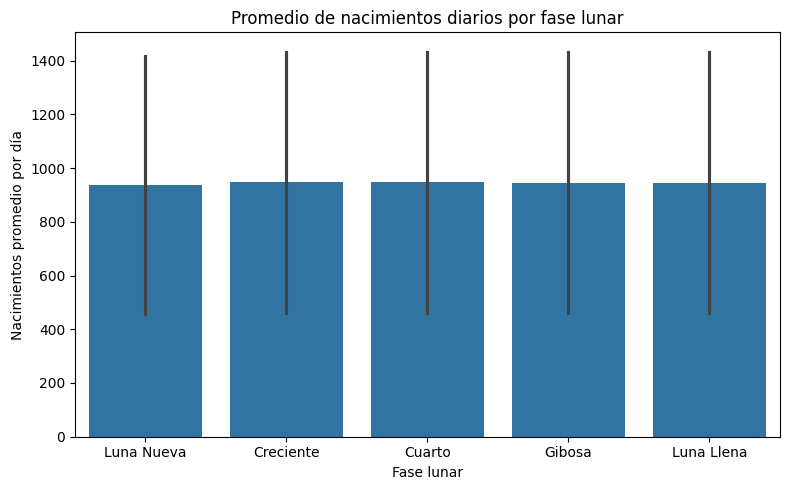

In [62]:
#Gráfico de barras con promedio de nacimientos

# Asegurarse que 'faseLunarNombre' está en el DataFrame
faseLabels = {
    1: 'Luna Nueva',
    2: 'Creciente',
    3: 'Cuarto',
    4: 'Gibosa',
    5: 'Luna Llena'
}
dfNacimientos['faseLunarNombre'] = dfNacimientos['faseLunarCod'].map(faseLabels)

# Orden personalizado
ordenFases = ['Luna Nueva', 'Creciente', 'Cuarto', 'Gibosa', 'Luna Llena']

# Crear gráfico
plt.figure(figsize=(8, 5))
sns.barplot(data=dfNacimientos, x='faseLunarNombre', y='births', estimator='mean', errorbar='sd', order=ordenFases)
plt.title('Promedio de nacimientos diarios por fase lunar')
plt.xlabel('Fase lunar')
plt.ylabel('Nacimientos promedio por día')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### BoxPlot para ver distribución

Queremos conocer la distribución de los nacimientos diarios clasificados según la fase lunar.

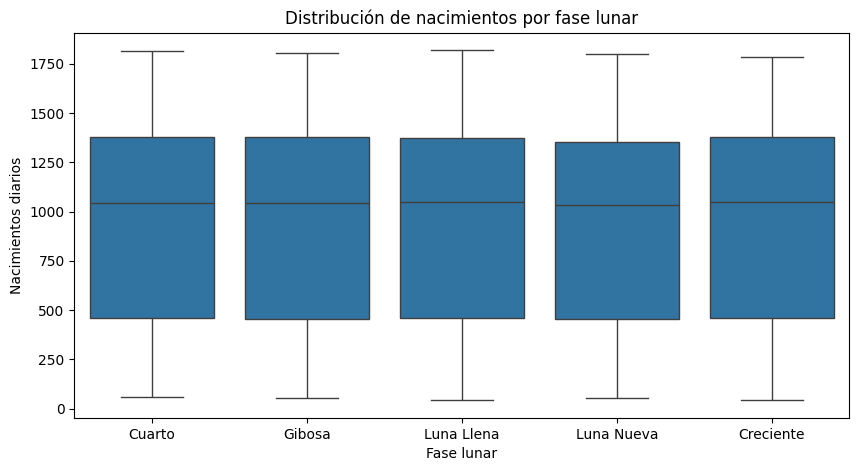

In [63]:
#Boxplot para ver distribución

plt.figure(figsize=(10,5))
sns.boxplot(data=dfNacimientos, x='faseLunarNombre', y='births')
plt.title('Distribución de nacimientos por fase lunar')
plt.ylabel('Nacimientos diarios')
plt.xlabel('Fase lunar')
plt.show()


### Prueba ANOVA

La prueba ANOVA de un solo factor nos dice si hay una diferencia estadísticamente significativa entre la cantidad de nacimientos en cada fase lunar.

Los resultados nos muestran que no hay ninguna evidencia que indique una influencia de la fase lunar en la cantidad de nacimientos.

In [64]:
#Prueba ANOVA

# Agrupar los nacimientos por fase
gruposNacimientos = [grupo['births'].values for _, grupo in dfNacimientos.groupby('faseLunarCod')]

# Ejecutar ANOVA
f_stat, p_valor = f_oneway(*gruposNacimientos)

# Mostrar resultados
print(f'Estadístico F: {f_stat:.4f}')
print(f'Valor p: {p_valor:.6f}')

if p_valor < 0.05:
    print("🎯 Hay diferencias estadísticamente significativas entre las fases lunares.")
else:
    print("🔍 No hay evidencia estadística de que la fase lunar afecte los nacimientos.")


Estadístico F: 0.4069
Valor p: 0.803854
🔍 No hay evidencia estadística de que la fase lunar afecte los nacimientos.


## Análisis por dia de la Semana

Hacemos ahora un análisis para determinar si hay variación estadísticamente importante en la cantidad de nacimientos según el dia de la semana.

In [65]:
#Análisis descriptivo por día de la semana

# Crear columna con el nombre del día de la semana
dfNacimientos['diaSemana'] = dfNacimientos['date'].dt.day_name()

resumenSemana = dfNacimientos.groupby('diaSemana')['births'].agg(
    cantidadDias='count',
    nacimientosTotales='sum',
    promedioDiario='mean',
    mediana='median',
    desviacion='std'
).sort_values(by='promedioDiario', ascending=False)

resumenSemana



,cantidadDias,nacimientosTotales,promedioDiario,mediana,desviacion
diaSemana,,,,,
Monday,5373,5201652,968.109436,1059.0,501.630366
Wednesday,5371,5187367,965.810277,1044.0,505.060436
Tuesday,5366,5174123,964.242080,1046.0,506.042632
Thursday,5366,5167526,963.012672,1052.5,500.330819
Friday,5381,5160921,959.100725,1053.0,492.122813
Saturday,5386,4895856,908.996658,1026.0,450.736674
Sunday,5384,4799494,891.436478,1030.0,432.203429


### Gráfico de Barra por dia de la semana

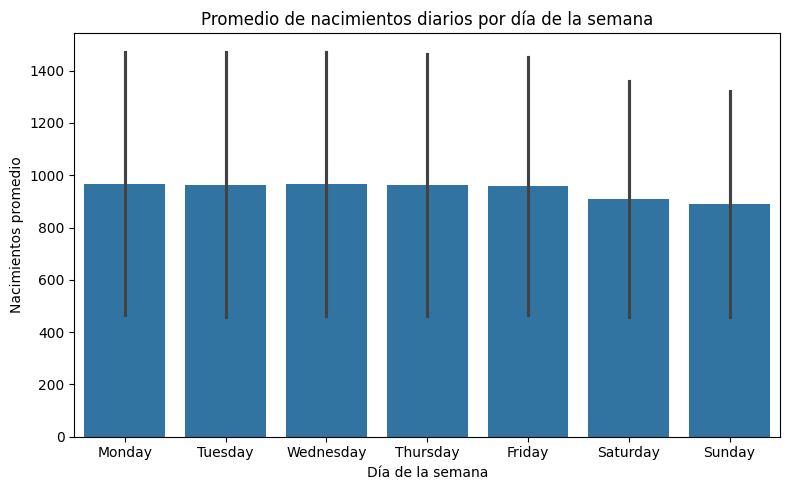

In [66]:
#Grafico de barras

ordenDias = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(8,5))
sns.barplot(data=dfNacimientos, x='diaSemana', y='births', order=ordenDias, estimator='mean', errorbar='sd')
plt.title('Promedio de nacimientos diarios por día de la semana')
plt.ylabel('Nacimientos promedio')
plt.xlabel('Día de la semana')
plt.tight_layout()
plt.show()

### Boxplot por dia de la Semana

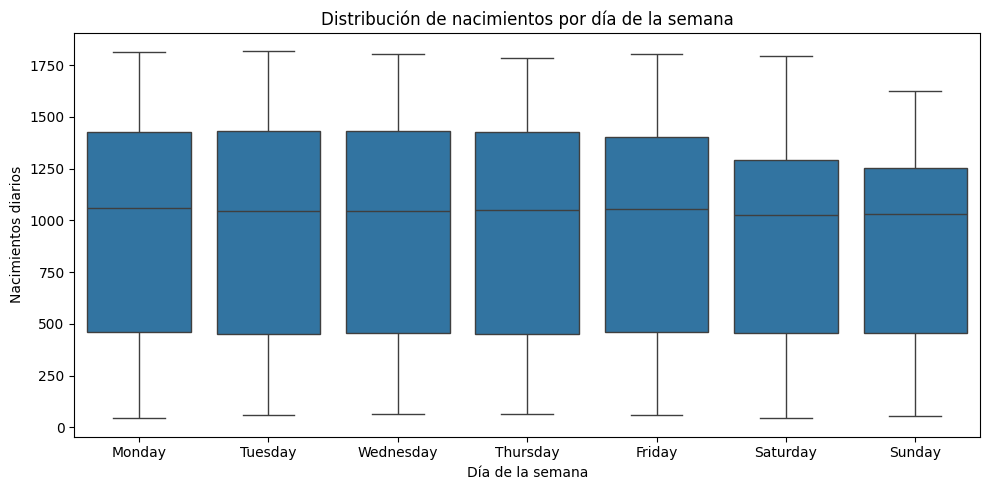

In [67]:
#Boxplot por dia de la semana

plt.figure(figsize=(10, 5))
sns.boxplot(
    data=dfNacimientos,
    x='diaSemana',
    y='births',
    order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)
plt.title('Distribución de nacimientos por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Nacimientos diarios')
plt.tight_layout()
plt.show()


### Prueba ANOVA para dia de la semana

El resultado de esta prueba indica que si hay diferencias estadísticas en la cantidad de nacimientos según el dia de la semana.

In [68]:
#Prueba ANOVA

# Crear los grupos de nacimientos por día de la semana en orden
ordenDias = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
gruposSemana = [dfNacimientos[dfNacimientos['diaSemana'] == dia]['births'].values for dia in ordenDias]

# Ejecutar ANOVA
f_stat, p_valor = f_oneway(*gruposSemana)

# Mostrar resultados
print(f'Estadístico F: {f_stat:.4f}')
print(f'Valor p: {p_valor:.6f}')

if p_valor < 0.05:
    print("🎯 Hay diferencias estadísticamente significativas entre los días de la semana.")
else:
    print("🔍 No hay evidencia estadística de que el día de la semana afecte los nacimientos.")

Estadístico F: 22.9770
Valor p: 0.000000
🎯 Hay diferencias estadísticamente significativas entre los días de la semana.


### Prueba Tukey HSD por dia de la semana

Siendo que la prueba ANOVA nos indica diferencias importantes entre los días de la semana, aplicamos una prueba Tukey para identificar los pares de días que presentan diferencias significativas.

Los resultados muestran que los fines de semana son diferentes en cantidad de nacimientos, las razones podrían ser varias, y aunque se desconocen se puede especular que podrían ser razones administrativas, sociales, etc.

In [69]:
#Prueba Tukey HSD por día de la semana

# Ejecutar prueba de Tukey
tukey = pairwise_tukeyhsd(endog=dfNacimientos['births'],
                          groups=dfNacimientos['diaSemana'],
                          alpha=0.05)

# Mostrar resultados
print(tukey)


    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
 group1    group2  meandiff p-adj    lower    upper   reject
------------------------------------------------------------
  Friday    Monday   9.0087 0.9617   -18.558  36.5754  False
  Friday  Saturday -50.1041    0.0  -77.6541  -22.554   True
  Friday    Sunday -67.6642    0.0  -95.2169 -40.1116   True
  Friday  Thursday   3.9119 0.9996  -23.6637  31.4876  False
  Friday   Tuesday   5.1414 0.9981  -22.4343  32.7171  False
  Friday Wednesday   6.7096 0.9916  -20.8597  34.2788  False
  Monday  Saturday -59.1128    0.0  -86.6731 -31.5525   True
  Monday    Sunday  -76.673    0.0 -104.2358 -49.1101   True
  Monday  Thursday  -5.0968 0.9982  -32.6827  22.4892  False
  Monday   Tuesday  -3.8674 0.9996  -31.4533  23.7186  False
  Monday Wednesday  -2.2992    1.0  -29.8787  25.2804  False
Saturday    Sunday -17.5602  0.494  -45.1064    9.986  False
Saturday  Thursday   54.016    0.0   26.4467  81.5853   True
Saturday   Tuesday  55.2

## Analisis por mes del año

In [70]:
# Crear columna con el nombre del mes
dfNacimientos['mesNombre'] = dfNacimientos['date'].dt.month_name()

dfNacimientos.head()


,date,state,births,anio,esOutlierAnual,mes,dia,promedioAnual,limiteOutlierAnual,edadLuna,faseLunarCod,faseLunarNombre,diaSemana,mesNombre
0,1920-01-01,Malaysia,96,1920,False,1,1,106.010929,219.95,9.545175,3.0,Cuarto,Thursday,January
1,1920-01-02,Malaysia,115,1920,False,1,2,106.010929,219.95,10.545175,4.0,Gibosa,Friday,January
2,1920-01-03,Malaysia,111,1920,False,1,3,106.010929,219.95,11.545175,4.0,Gibosa,Saturday,January
3,1920-01-04,Malaysia,101,1920,False,1,4,106.010929,219.95,12.545175,4.0,Gibosa,Sunday,January
4,1920-01-05,Malaysia,95,1920,False,1,5,106.010929,219.95,13.545175,5.0,Luna Llena,Monday,January


### Analisis por mes

In [71]:
#Analisis descriptivo por mes

resumenMes = dfNacimientos.groupby('mesNombre')['births'].agg(
    cantidadDias='count',
    nacimientosTotales='sum',
    promedioDiario='mean',
    mediana='median',
    desviacion='std'
).sort_values(by='promedioDiario', ascending=False)

resumenMes


,cantidadDias,nacimientosTotales,promedioDiario,mediana,desviacion
mesNombre,,,,,
October,3169,3114992,982.957400,1037.0,503.354972
September,3065,2990980,975.849918,1026.0,515.062838
November,3075,2959288,962.370081,1003.0,487.600366
June,3119,2994458,960.069894,1079.0,480.769781
May,3221,3087550,958.568767,1086.0,490.022902
August,3189,3030717,950.365945,1042.0,492.484342
July,3222,3047786,945.929857,1045.0,476.448134
April,3120,2949609,945.387500,1081.0,480.633673
December,3135,2915592,930.013397,941.0,452.950573


### Grafico de Barras por mes

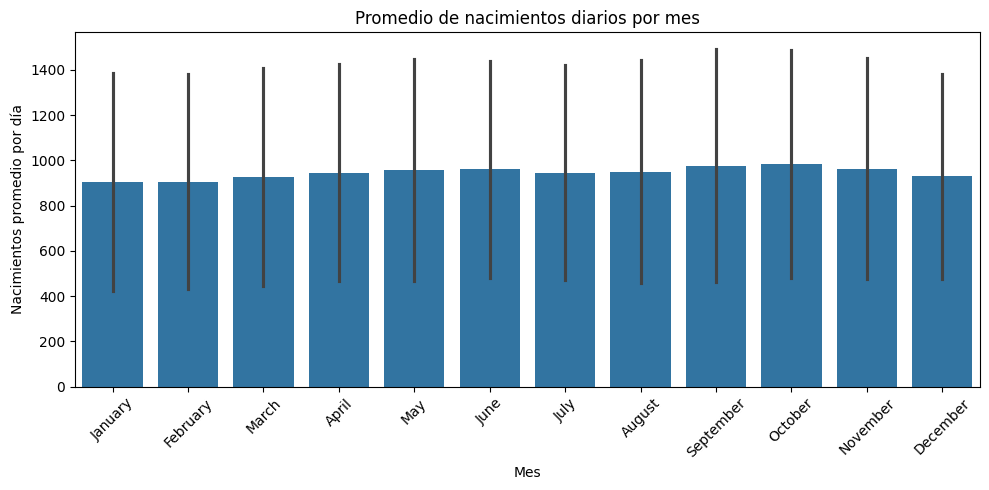

In [72]:
#Grafico de Barras por mes del año

# Orden cronológico de los meses
ordenMeses = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]

plt.figure(figsize=(10,5))
sns.barplot(data=dfNacimientos, x='mesNombre', y='births', order=ordenMeses, estimator='mean', errorbar='sd')
plt.title('Promedio de nacimientos diarios por mes')
plt.xlabel('Mes')
plt.ylabel('Nacimientos promedio por día')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Boxplot por mes

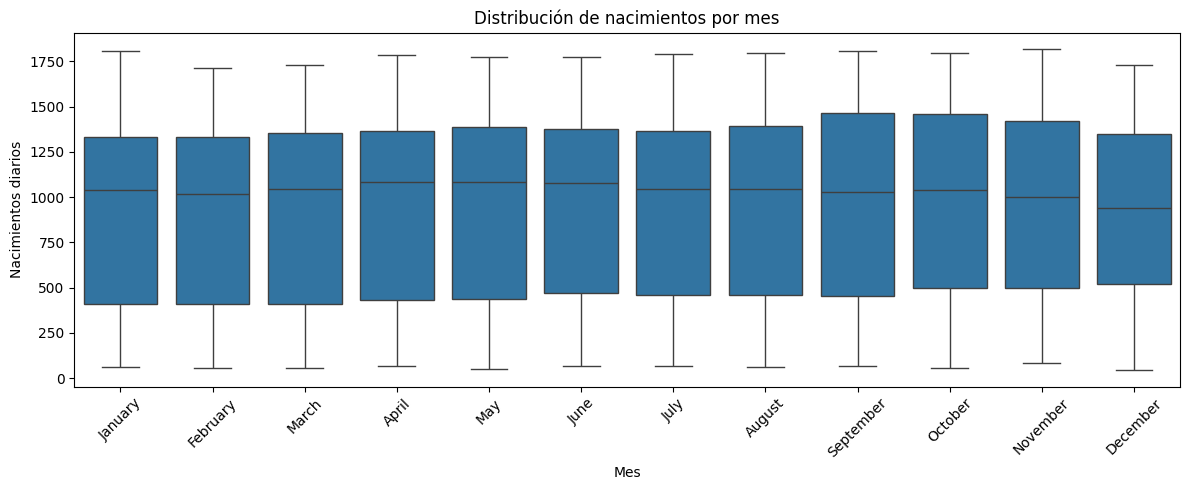

In [73]:
#Boxplot por mes del año

# Orden cronológico de los meses
ordenMeses = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]

# Gráfico boxplot
plt.figure(figsize=(12, 5))
sns.boxplot(data=dfNacimientos, x='mesNombre', y='births', order=ordenMeses)
plt.title('Distribución de nacimientos por mes')
plt.xlabel('Mes')
plt.ylabel('Nacimientos diarios')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Prueba ANOVA por mes

La prueba ANOVA nos indica que hay diferencias en la cantidad de nacimientos según el mes del año, particularmente septiembre y octubre se destacan como los meses con mas nacimientos.

In [74]:
#Prueba ANOVA por mes del año

# Orden cronológico de los meses
ordenMeses = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]

# Crear los grupos de nacimientos por mes
gruposMes = [dfNacimientos[dfNacimientos['mesNombre'] == mes]['births'].values for mes in ordenMeses]

# Ejecutar ANOVA
f_stat, p_valor = f_oneway(*gruposMes)

# Mostrar resultados
print(f'Estadístico F: {f_stat:.4f}')
print(f'Valor p: {p_valor:.6f}')

if p_valor < 0.05:
    print("🎯 Hay diferencias estadísticamente significativas entre los meses.")
else:
    print("🔍 No hay evidencia estadística de que el mes afecte los nacimientos.")


Estadístico F: 8.2459
Valor p: 0.000000
🎯 Hay diferencias estadísticamente significativas entre los meses.


### Prueba Tukey HSD para mes

La prueba Tukey nos indica la variación comparativa de los meses.

In [75]:
#Prueba Tukey HSD para mes del año

# Prueba de Tukey para nacimientos por mes
tukeyMes = pairwise_tukeyhsd(endog=dfNacimientos['births'],
                              groups=dfNacimientos['mesNombre'],
                              alpha=0.05)

# Mostrar resultados
print(tukeyMes)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1    group2  meandiff p-adj   lower    upper   reject
-----------------------------------------------------------
   April    August   4.9784    1.0  -34.945  44.9018  False
   April  December -15.3741 0.9845 -55.4672   24.719  False
   April  February   -40.53 0.0531 -81.3023   0.2424  False
   April   January -40.1549 0.0484 -80.1845  -0.1252   True
   April      July   0.5424    1.0 -39.2798  40.3645  False
   April      June  14.6824 0.9894 -25.4619  54.8267  False
   April     March -19.1989  0.918  -59.018  20.6203  False
   April       May  13.1813 0.9955 -26.6439  53.0065  False
   April  November  16.9826 0.9679 -23.3051  57.2703  False
   April   October  37.5699 0.0893  -2.4158  77.5556  False
   April September  30.4624 0.3596  -9.8584  70.7832  False
  August  December -20.3525 0.8828 -60.2276  19.5225  False
  August  February -45.5084 0.0131 -86.0664  -4.9504   True
  August   January -45.1333 0.0114 -84.9

### Tukey solo Reject=True

Aquí listamos solo las combinaciones de meses que tienen una diferencia significativa.

In [76]:
#Tukey solo reject=True

# Convertir resultados de Tukey a DataFrame
tukeyDf = pd.DataFrame(data=tukeyMes._results_table.data[1:], columns=tukeyMes._results_table.data[0])

# Filtrar solo donde hay diferencia significativa
tukeySignificativo = tukeyDf[tukeyDf['reject'] == True]

# Mostrar los pares con diferencia significativa
tukeySignificativo


,group1,group2,meandiff,p-adj,lower,upper,reject
3,April,January,-40.1549,0.0484,-80.1845,-0.1252,True
12,August,February,-45.5084,0.0131,-86.0664,-4.9504,True
13,August,January,-45.1333,0.0114,-84.9446,-5.3220,True
28,December,October,52.9440,0.0009,13.0066,92.8814,True
29,December,September,45.8365,0.0108,5.5636,86.1095,True
31,February,July,41.0723,0.0428,0.6140,81.5307,True
32,February,June,55.2124,0.0006,14.4368,95.9879,True
34,February,May,53.7112,0.0009,13.2499,94.1726,True
35,February,November,57.5125,0.0003,16.5959,98.4292,True
36,February,October,78.0999,0.0000,37.4806,118.7192,True


### Visualizar Heatmap de meses

Este Heatmap nos muestra la diferencia (positivo o negativo) de medias entre la combinación de meses.

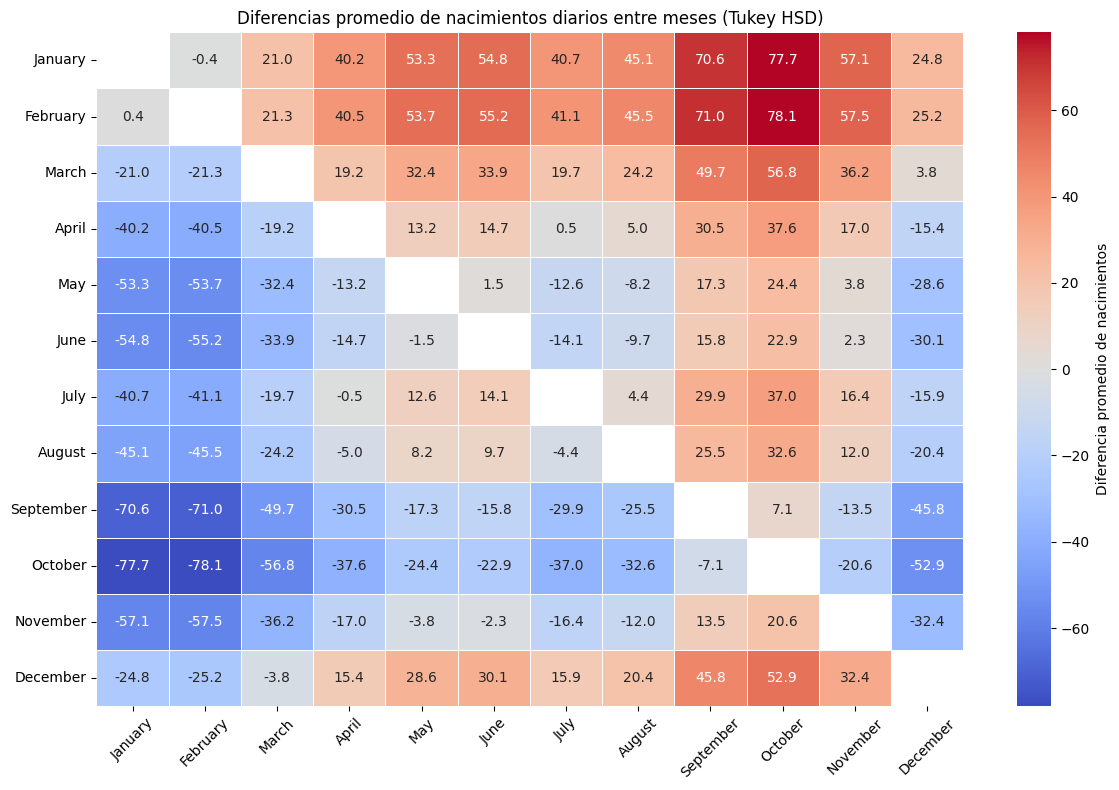

In [77]:
#Visualizar heatmap de los meses

# Convertir resultados de Tukey a DataFrame (si no lo hiciste ya)
tukeyDf = pd.DataFrame(data=tukeyMes._results_table.data[1:], columns=tukeyMes._results_table.data[0])

# Crear matriz 12x12 llena de NaNs
meses = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]
matrizCompleta = pd.DataFrame(np.nan, index=meses, columns=meses)

# Llenar la matriz con todas las diferencias de medias
for _, row in tukeyDf.iterrows():
    g1 = row['group1']
    g2 = row['group2']
    diff = row['meandiff']
    matrizCompleta.loc[g1, g2] = diff
    matrizCompleta.loc[g2, g1] = -diff  # reflejo simétrico

# Crear el heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(matrizCompleta, annot=True, cmap='coolwarm', center=0, fmt=".1f", linewidths=.5, cbar_kws={'label': 'Diferencia promedio de nacimientos'})
plt.title('Diferencias promedio de nacimientos diarios entre meses (Tukey HSD)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Heatmap de Tukey con absoluto de la diferencia

Para mayor claridad, mostramos el mismo Heatmap pero con el valor absoluto de la diferencia en pares de meses.

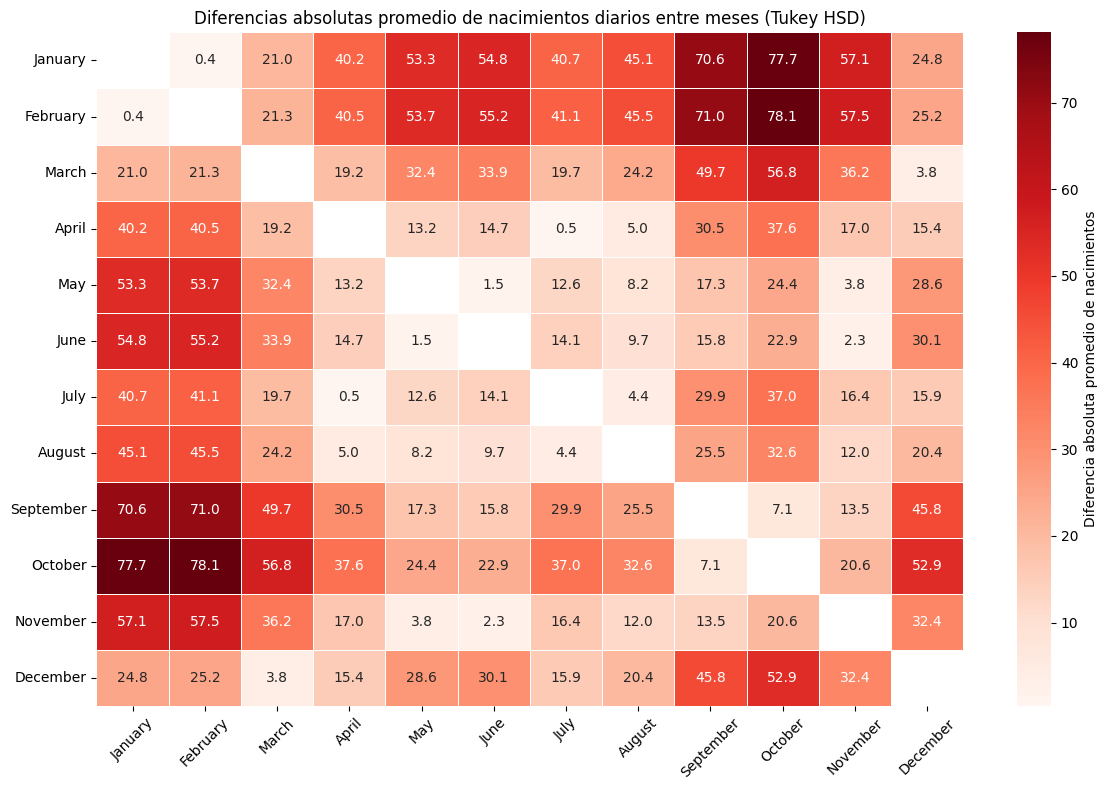

In [78]:
#Heatmap de Tukey con absoluto de la diferencia

# Convertir resultados de Tukey a DataFrame
tukeyDf = pd.DataFrame(data=tukeyMes._results_table.data[1:], columns=tukeyMes._results_table.data[0])

# Crear matriz 12x12 llena de NaNs
meses = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]
matrizAbs = pd.DataFrame(np.nan, index=meses, columns=meses)

# Llenar la matriz con el valor absoluto de las diferencias de medias
for _, row in tukeyDf.iterrows():
    g1 = row['group1']
    g2 = row['group2']
    absDiff = abs(float(row['meandiff']))
    matrizAbs.loc[g1, g2] = absDiff
    matrizAbs.loc[g2, g1] = absDiff  # reflejo simétrico

# Crear el heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(matrizAbs, annot=True, cmap='Reds', fmt=".1f", linewidths=.5,
            cbar_kws={'label': 'Diferencia absoluta promedio de nacimientos'})
plt.title('Diferencias absolutas promedio de nacimientos diarios entre meses (Tukey HSD)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Agregar recuadro a celdas con TRUE

Para identificar aquellas combinaciones con diferencia significativa, remarcamos el cuadro correspondiente.

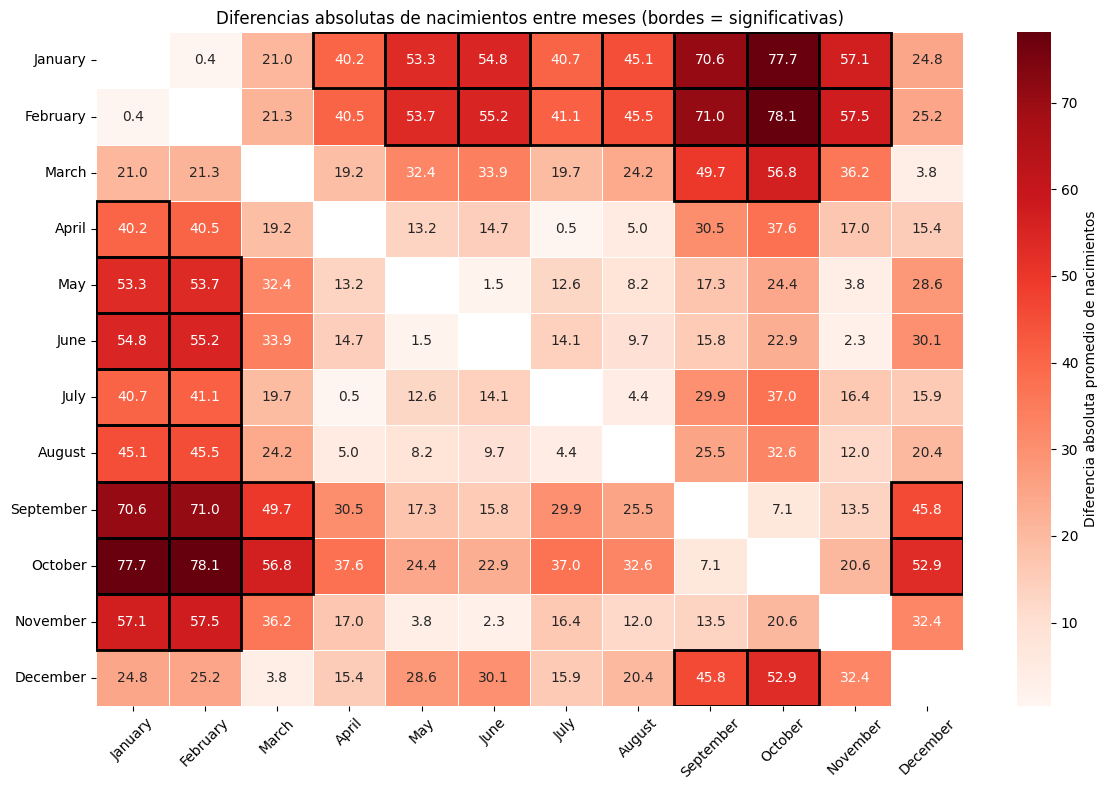

In [79]:
# Parámetros de visualización
bordeColor = 'black'
bordeGrosor = 2

# Convertir resultado de Tukey a DataFrame
tukeyDf = pd.DataFrame(data=tukeyMes._results_table.data[1:], columns=tukeyMes._results_table.data[0])
tukeyDf['meandiff'] = tukeyDf['meandiff'].astype(float)
tukeyDf['reject'] = tukeyDf['reject'].astype(bool)

# Definir orden cronológico de meses
meses = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]

# Inicializar matriz de diferencias absolutas
matrizAbs = pd.DataFrame(np.nan, index=meses, columns=meses)

# Llenar la matriz con valores absolutos (simétricos)
for _, row in tukeyDf.iterrows():
    g1, g2 = row['group1'], row['group2']
    absDiff = abs(row['meandiff'])
    matrizAbs.loc[g1, g2] = absDiff
    matrizAbs.loc[g2, g1] = absDiff

# Crear el heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(matrizAbs, annot=True, fmt=".1f", cmap='Reds',
                 linewidths=0.5, cbar_kws={'label': 'Diferencia absoluta promedio de nacimientos'})

# Dibujar bordes donde reject == True
for _, row in tukeyDf[tukeyDf['reject'] == True].iterrows():
    i, j = meses.index(row['group1']), meses.index(row['group2'])
    ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor=bordeColor, lw=bordeGrosor))
    ax.add_patch(plt.Rectangle((i, j), 1, 1, fill=False, edgecolor=bordeColor, lw=bordeGrosor))

# Finalizar visualización
plt.title('Diferencias absolutas de nacimientos entre meses (bordes = significativas)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Análisis de tendencia con los años

Veamos ahora como ha variado y cual es la tendencia en los años.

In [80]:
#Análisis descriptivo por año

#Agregamos columna anio
dfNacimientos['anio'] = dfNacimientos['date'].dt.year

resumenAnual = dfNacimientos.groupby('anio')['births'].agg(
    cantidadDias='count',
    nacimientosTotales='sum',
    promedioDiario='mean',
    mediana='median',
    desviacion='std'
).reset_index()

resumenAnual




,anio,cantidadDias,nacimientosTotales,promedioDiario,mediana,desviacion
0,1920,364,37448,102.879121,99.0,26.330841
1,1921,363,41027,113.022039,110.0,26.526117
2,1922,363,36928,101.730028,99.0,24.174866
3,1923,363,58118,160.104683,156.0,38.267091
4,1924,364,74498,204.664835,199.0,48.510915
...,...,...,...,...,...,...
99,2019,363,497708,1371.096419,1407.0,136.703753
100,2020,364,482309,1325.024725,1361.0,134.763161
101,2021,363,454873,1253.093664,1298.0,135.710987
102,2022,363,434438,1196.798898,1201.0,160.298257


### Grafico de Linea por años

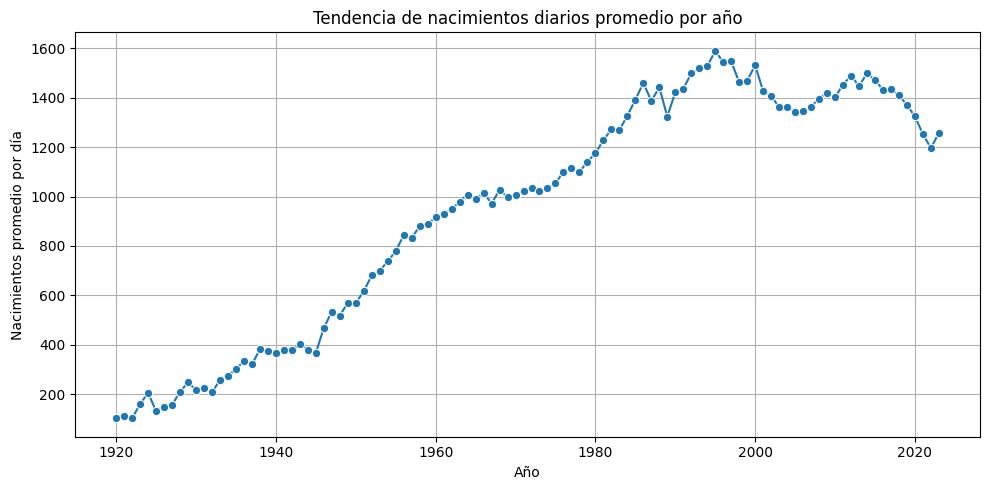

In [81]:
#Gráfico de línea (tendencia)

plt.figure(figsize=(10, 5))
sns.lineplot(data=resumenAnual, x='anio', y='promedioDiario', marker='o')
plt.title('Tendencia de nacimientos diarios promedio por año')
plt.xlabel('Año')
plt.ylabel('Nacimientos promedio por día')
plt.grid(True)
plt.tight_layout()
plt.show()


## Análisis por Décadas

Ahora veamos el comportamiento por décadas.

In [82]:
#Análisis por décadas

dfNacimientos['decada'] = (dfNacimientos['anio'] // 10) * 10

resumenDecadas = dfNacimientos.groupby('decada')['births'].agg(
    cantidadDias='count',
    nacimientosTotales='sum',
    promedioDiario='mean',
    mediana='median',
    desviacion='std'
).reset_index()

resumenDecadas



,decada,cantidadDias,nacimientosTotales,promedioDiario,mediana,desviacion
0,1920,3633,572487,157.579686,147.0,58.945481
1,1930,3633,1050723,289.216350,281.0,80.431525
2,1940,3633,1585515,436.420314,418.0,103.030537
3,1950,3632,2734193,752.806443,749.0,139.794598
4,1960,3633,3555124,978.564272,958.0,132.370391
5,1970,3632,3861203,1063.106553,1061.0,97.317867
6,1980,3633,4824592,1327.991192,1326.0,122.128408
7,1990,3632,5456376,1502.306167,1503.0,110.394680
8,2000,3633,5073686,1396.555464,1405.0,129.555852
9,2010,3633,5237335,1441.600606,1459.0,140.319104


### Gráfico de barra por década

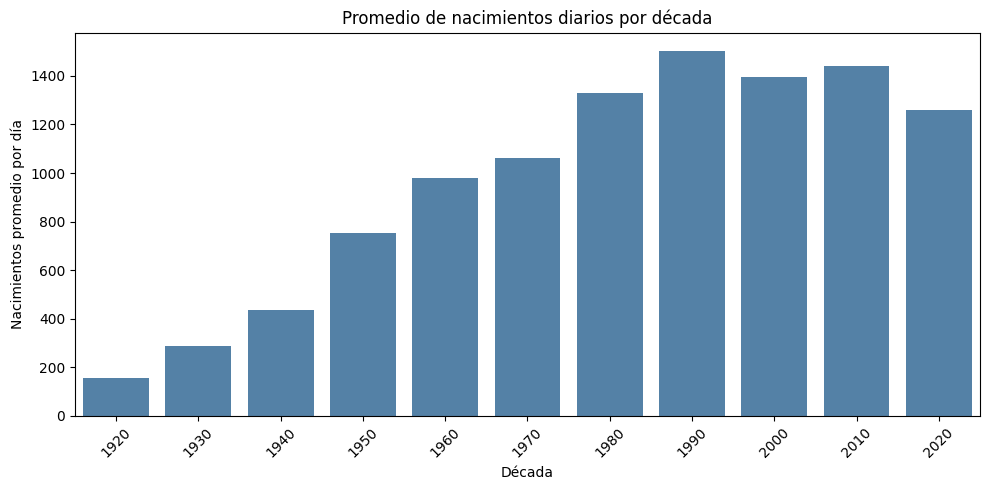

In [83]:
#Gráfico de barras por década

plt.figure(figsize=(10, 5))
sns.barplot(data=resumenDecadas, x='decada', y='promedioDiario', color='steelblue')
plt.title('Promedio de nacimientos diarios por década')
plt.xlabel('Década')
plt.ylabel('Nacimientos promedio por día')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Exportar el dataframe final

Exportamos los archivos para estudios y usos adicionales.

In [84]:
# Exportar DataFrame completo a CSV
dfNacimientos.to_csv("NacimientosCompleto.csv", index=False, encoding='utf-8-sig')


### Exportar archivo para matrix plot

In [85]:
#Archivo para el matrix plot

# Base inicial
dfBase = tukeyDf[['group1', 'group2', 'meandiff', 'reject']].copy()
dfBase.columns = ['mesFila', 'mesCol', 'valorOriginal', 'significativo']

# Crear inverso para simetría
dfInverso = dfBase.copy()
dfInverso['mesFila'], dfInverso['mesCol'] = dfBase['mesCol'], dfBase['mesFila']
dfInverso['valorOriginal'] = dfInverso['valorOriginal']

# Unir ambas partes
dfCompleto = pd.concat([dfBase, dfInverso], ignore_index=True)

# Convertir a valor absoluto
dfCompleto['valor'] = dfCompleto['valorOriginal'].abs()

# Reemplazar True/False con ✔ y ""
dfCompleto['significativo'] = dfCompleto['significativo'].apply(lambda x: '✔' if x else '')

# Agregar la diagonal (mes vs mes)
ordenMeses = ['January', 'February', 'March', 'April', 'May', 'June',
              'July', 'August', 'September', 'October', 'November', 'December']
diagonal = pd.DataFrame({
    'mesFila': ordenMeses,
    'mesCol': ordenMeses,
    'valorOriginal': [0]*12,
    'significativo': ['']*12,
    'valor': [0]*12
})

# Combinar todo
dfCompleto = pd.concat([dfCompleto, diagonal], ignore_index=True)

# Agregar número de mes
mapaMesNumero = {mes: i+1 for i, mes in enumerate(ordenMeses)}
dfCompleto['numMesFila'] = dfCompleto['mesFila'].map(mapaMesNumero)
dfCompleto['numMesCol'] = dfCompleto['mesCol'].map(mapaMesNumero)

# Ordenar categorías
dfCompleto['mesFila'] = pd.Categorical(dfCompleto['mesFila'], categories=ordenMeses, ordered=True)
dfCompleto['mesCol'] = pd.Categorical(dfCompleto['mesCol'], categories=ordenMeses, ordered=True)

# Ordenar para visualización
dfCompleto = dfCompleto.sort_values(['numMesFila', 'numMesCol'])

# Exportar
dfCompleto.to_csv('ComparacionesMeses.csv', index=False)
print("✅ Archivo exportado como 'ComparacionesMeses.csv'")


✅ Archivo exportado como 'ComparacionesMeses.csv'


---

**Autor**: DataScience504  
**Proyecto**: Exploración de patrones de nacimientos y fases lunares  
**Contacto**: datashn504@gmail.com

---
